In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from polygon import RESTClient
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm
from dotenv import load_dotenv
import os
import time

pd.options.mode.chained_assignment = None

In [2]:
start='1999-01-01'
end='2025-03-20'
directory='data/prices_1_day'

## S&P500 Historical components

In [3]:
# Dateranges in S&P500 list for each ticker
hc = pd.read_csv('data/external/sp500_ticker_start_end.csv')
hc

,ticker,start_date,end_date
0,A,2000-06-05,NaN
1,AABA,1999-12-08,2017-06-19
2,AAL,1996-01-02,1997-01-15
3,AAL,2015-03-23,2024-09-23
4,AAMRQ,1996-01-02,2003-03-14
...,...,...,...
1219,YUM,1997-10-07,NaN
1220,ZBH,2001-08-07,NaN
1221,ZBRA,2019-12-23,NaN
1222,ZION,2001-06-25,2024-03-18


In [4]:
# Example of Stocks presented in SP500 more than once.

counts = hc.groupby(by=['ticker'])['start_date'].count().reset_index()
counts[counts['start_date']>1].head()

,ticker,start_date
2,AAL,2
57,AMD,2
62,AMP,2
66,AN,2
164,BR,2


## Data Collection Process

In [ ]:
def history(ticker:str, start:str, end:str)->pd.DataFrame:
    data = yf.Ticker(ticker).history(start=start, end=end, auto_adjust=False).reset_index()
    data['Date'] = pd.to_datetime(data['Date']).dt.date.astype(str)
    data['Ticker'] = ticker
    return data

def check_sp500_listing(batch:pd.DataFrame)->pd.DataFrame:
    sp500_periods = hc[hc['ticker']=='AMD'].fillna(datetime.now().strftime('%Y-%m-%d'))
    periods = tuple(zip(sp500_periods['start_date'], sp500_periods['end_date']))
    batch['in_sp500'] = False 
    for p in periods:
        batch['after_sd'] = batch['Date'] > p[0]
        batch['before_ed'] = batch['Date'] < p[1]
        batch['in_sp500'] = batch['in_sp500'] + (batch['after_sd'] * batch['before_ed'])

    batch['in_sp500'] = batch['in_sp500'].astype(int)
    return batch

def technical_indicators(data:pd.DataFrame)->pd.DataFrame:

    def sma(df, column, intervals):
        '''
        SMA - Simple Moving Average
        '''
        
        for i in intervals:
            df[f'{column}_SMA_{i}'] = df[column].rolling(window=i).mean()
        return df

    def ema(df, column, intervals):
        '''
        EMA - Exponential Moving Average
        '''
                
        for i in intervals:
            df[f'{column}_EMA_{i}'] = df[column].ewm(span=i, adjust=False).mean()
        return df
    
    def rsi(df, column):
        '''
        RSI - Relative Strength Index
        '''
        delta = df[column].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        for i in [7, 14]:
    
            avg_gain = gain.rolling(window=i).mean()
            avg_loss = loss.rolling(window=i).mean()
        
            for j in range(i, len(df)):
                avg_gain.iloc[j] = (avg_gain.iloc[j-1] * (i-1) + gain.iloc[j]) / i
                avg_loss.iloc[j] = (avg_loss.iloc[j-1] * (i-1) + loss.iloc[j]) / i
            
            rs = avg_gain / avg_loss
            df[f'RSI_{i}'] = 100 - (100 / (1 + rs))
        return df
    
    def bb(df, column):
        '''
        Bollinger Bands (Upper and lower Bands)
        '''
        std_dev = df[column].rolling(window=20).std()
        df[f'{column}_SMA_20'] = df[column].rolling(window=20).mean()
        df['BB_U_Band'] = df[f'{column}_SMA_20'] + (2 * std_dev)
        df['BB_L_Band'] = df[f'{column}_SMA_20'] - (2 * std_dev)
        return df

    data = sma(data, 'Close', [7, 50, 200])
    data = sma(data, 'Volume', [7, 50, 200])
    data = ema(data, 'Close', [7, 50, 200])
    data = rsi(data, 'Close')
    data = bb(data, 'Close')

    return data

# hc['ticker'].unique()

for ticker in tqdm(['SPY']):
    batch = yf.Ticker(ticker).history(start=start, end=end, auto_adjust=False).reset_index()
    batch['Date'] = pd.to_datetime(batch['Date']).dt.date.astype(str)
    batch['Ticker'] = ticker

    batch = check_sp500_listing(batch)

    batch['in_sp500'] = batch['in_sp500'].astype(int)
    batch = batch[['Date', 'Ticker', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'in_sp500']]
    batch = technical_indicators(batch)
    batch = batch[batch['Date'] > '2000-01-01'].reset_index(drop=True)
    batch.to_csv(f'{directory}/{ticker}_daily_stock_prices.csv', index=False)

    time.sleep(1)
    


  0%|          | 0/1 [00:01<?, ?it/s]


NameError: name 'i' is not defined

In [ ]:
def plot_indicators(df):
    plt.style.use('ggplot')
    
    ticker_symbol = df['Ticker'].values[0]
    # Создаем подграфики
    fig, axs = plt.subplots(4, 1, figsize=(14, 24), gridspec_kw={'height_ratios': [3, 3, 1, 1, 1]})
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    # SMA Plot
    axs[0].plot(df['Date'], df['Close'], label='Close Price', alpha=0.7)
    axs[0].plot(df['Date'], df['SMA_20'], label='SMA 20', linestyle='--')
    axs[0].plot(df['Date'], df['SMA_50'], label='SMA 50', linestyle='--')
    axs[0].plot(df['Date'], df['SMA_200'], label='SMA 200', linestyle='--')
    axs[0].set_title(f'{ticker_symbol} - Price and Moving Averages')
    axs[0].legend()

    # EMA Plot
    axs[1].plot(df['Date'], df['Close'], label='Close Price', alpha=0.7)
    axs[1].plot(df['Date'], df['EMA_20'], label='EMA 20', linestyle='--')
    axs[1].plot(df['Date'], df['EMA_50'], label='EMA 50', linestyle='--')
    axs[1].plot(df['Date'], df['EMA_200'], label='EMA 200', linestyle='--')
    axs[1].set_title(f'{ticker_symbol} - Price and Exp. Moving Averages')
    axs[1].legend()
    
    # RSI(7) Plots
    axs[2].plot(df['Date'], df['RSI_7'], color='purple', alpha=0.7)
    axs[2].axhline(y=70, color='r', linestyle='--', alpha=0.5)
    axs[2].axhline(y=30, color='g', linestyle='--', alpha=0.5)
    axs[2].fill_between(df['Date'], df['RSI_7'], 70, where=df['RSI_7'] > 70, color='r', alpha=0.3)
    axs[2].fill_between(df['Date'], df['RSI_7'], 30, where=df['RSI_7'] < 30, color='g', alpha=0.3)
    axs[2].set_title(f'{ticker_symbol} - RSI (7)')
    axs[2].set_ylim(0, 100)

    # RSI(14) Plot
    axs[3].plot(df['Date'], df['RSI_14'], color='purple', alpha=0.7)
    axs[3].axhline(y=70, color='r', linestyle='--', alpha=0.5)
    axs[3].axhline(y=30, color='g', linestyle='--', alpha=0.5)
    axs[3].fill_between(df['Date'], df['RSI_14'], 70, where=df['RSI_14'] > 70, color='r', alpha=0.3)
    axs[3].fill_between(df['Date'], df['RSI_14'], 30, where=df['RSI_14'] < 30, color='g', alpha=0.3)
    axs[3].set_title(f'{ticker_symbol} - RSI (14)')
    axs[3].set_ylim(0, 100)


    # 4. График Bollinger Bands
    axs[4].plot(df['Date'], df['Close'], label='Close Price', alpha=0.7)
    axs[4].plot(df['Date'], df['BB_U_Band'], label='Upper Band', linestyle='--', alpha=0.7)
    axs[4].plot(df['Date'], df['BB_L_Band'], label='Lower Band', linestyle='--', alpha=0.7)
    axs[4].fill_between(df['Date'], df['BB_U_Band'], df['BB_L_Band'], alpha=0.1)
    axs[4].set_title(f'{ticker_symbol} - Bollinger Bands')
    axs[4].legend()

    
    # plt.tight_layout()
    plt.show()

In [ ]:
batch

,Date,Ticker,Close,Volume,Dividends,Stock Splits,in_sp500,SMA_7,SMA_20,SMA_50,SMA_200,EMA_7,EMA_20,EMA_50,EMA_200,RSI_7,RSI_14
0,2000-01-03,SPY,145.437500,8164300,0.0,0.0,1,146.388393,143.598437,140.252500,134.929844,145.825141,144.033322,140.783446,134.806413,55.109635,60.123229
1,2000-01-04,SPY,139.750000,8089800,0.0,0.0,1,145.426339,143.446875,140.445625,134.978906,144.306356,143.625387,140.742919,134.855603,24.872470,39.912317
2,2000-01-05,SPY,140.000000,12177900,0.0,0.0,1,144.529018,143.365625,140.656875,135.047969,143.229767,143.280112,140.713785,134.906791,26.928488,40.853504
3,2000-01-06,SPY,137.750000,6227200,0.0,0.0,1,143.323661,143.217187,140.855625,135.102188,141.859825,142.753435,140.597558,134.935081,20.917703,35.468775
4,2000-01-07,SPY,145.750000,8066500,0.0,0.0,1,143.171875,143.434375,141.168125,135.183437,142.832369,143.038822,140.799615,135.042693,58.937913,57.113342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6336,2025-03-13,SPY,551.419983,74079400,0.0,0.0,1,565.497140,586.924997,593.061799,572.386499,564.015119,579.811658,589.069714,569.031832,22.273171,28.148829
6337,2025-03-14,SPY,562.809998,62660300,0.0,0.0,1,562.604283,584.578998,592.553600,572.553349,563.713839,578.192452,588.039922,568.969923,39.781463,37.709813
6338,2025-03-17,SPY,567.150024,49008700,0.0,0.0,1,561.809998,582.451498,592.175000,572.740049,564.572885,577.140792,587.220710,568.951815,45.262615,40.934978
6339,2025-03-18,SPY,561.020020,66041400,0.0,0.0,1,559.681431,579.928000,591.702600,572.914650,563.684669,575.605481,586.193232,568.872892,39.359203,37.946455


/var/folders/b2/17vn_90d5t93nhh5__zt6tb80000gn/T/ipykernel_75342/1168071087.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']).dt.date


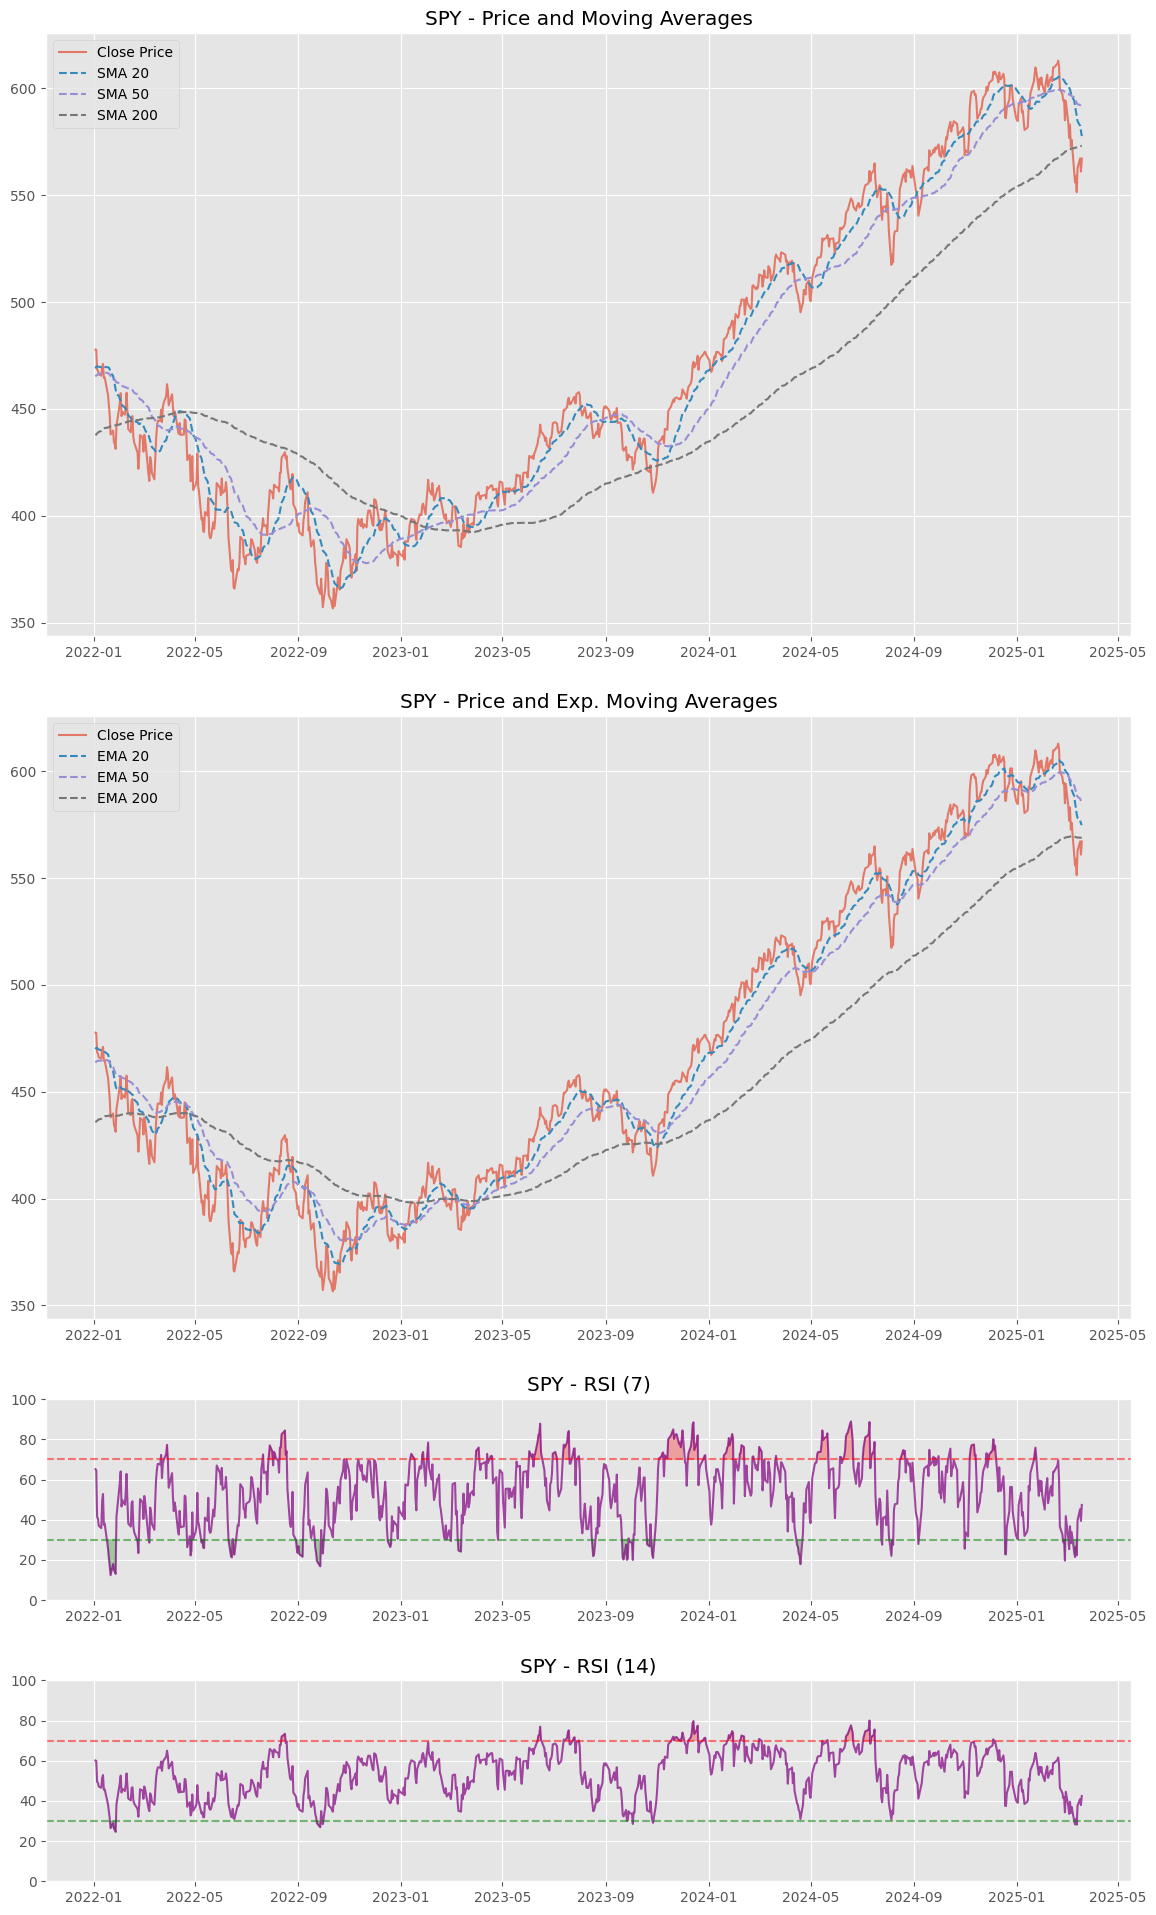

In [ ]:
plot_indicators(batch[batch['Date'] > '2022-01-01'])